## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [316]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#TensorFlow e Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

#Scikit-Learn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    ConfusionMatrixDisplay, multilabel_confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

#Imbalanced-Learn
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler





**QUESTION:** Load dataset and display some lines of the csv file.

In [339]:
data_path = "/content/ai4i2020.csv"

df = pd.read_csv(data_path)

df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

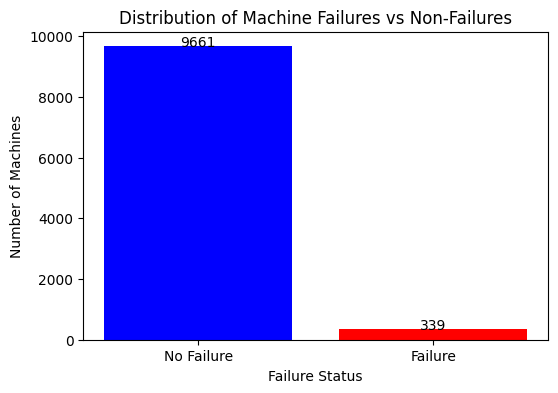

In [340]:

counts_machine_failure = df['Machine failure'].value_counts()

labels = ['No Failure', 'Failure']
values = [counts_machine_failure.get(0, 0), counts_machine_failure.get(1, 0)]

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=['blue', 'red'])
plt.title("Distribution of Machine Failures vs Non-Failures")
plt.xlabel("Failure Status")
plt.ylabel("Number of Machines")

for i, v in enumerate(values):
    plt.text(i, v + 0.5, str(int(v)), ha='center')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

Há muitas maquinas que não houveram falhas em compararação com máquinas que tiveram falhas.



**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Porteriormente ao usar esses dados para treinar a IA, pode acarretar em um bom aprendizado para detectar apenas quando não há falhas, resultando em mal aprendizado para identificar quando há falhas também.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

<ipython-input-341-235485598937>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette=['blue', 'orange', 'green', 'red', 'purple'] )


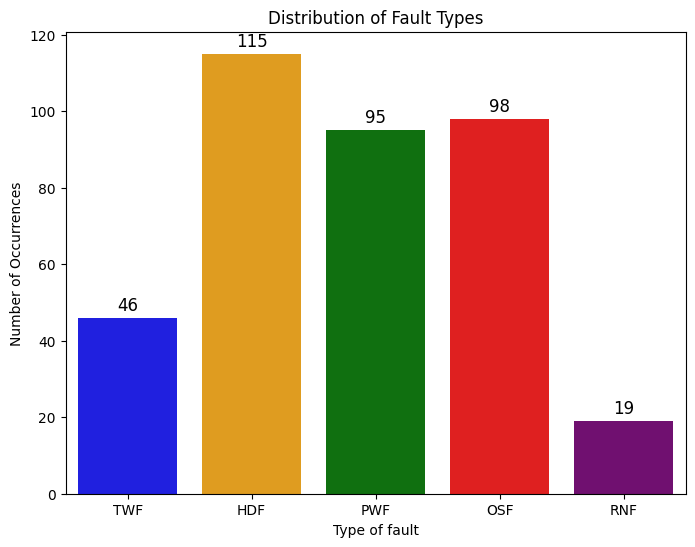

In [341]:
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = df[failure_types].sum()

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette=['blue', 'orange', 'green', 'red', 'purple'] )

for i, value in enumerate(failure_counts.values):
    ax.text(i, value + 2, str(value), ha='center', fontsize=12)

plt.xlabel("Type of fault")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Fault Types")

plt.show()

**ANALYSIS QUESTION:** What do you observe?

Mesmo em comparação com as maquinas que tiveram falhas, ainda sim há um diferença entre os tipos de falhas, onde 19 foram categorizadas como RNF e 115 foram caracterizadas como HDF.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

<ipython-input-342-708757154ff1>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=failure_counts.index, y=failure_counts.values,  palette=['blue', 'orange', 'green', 'red', 'purple', 'gray'])


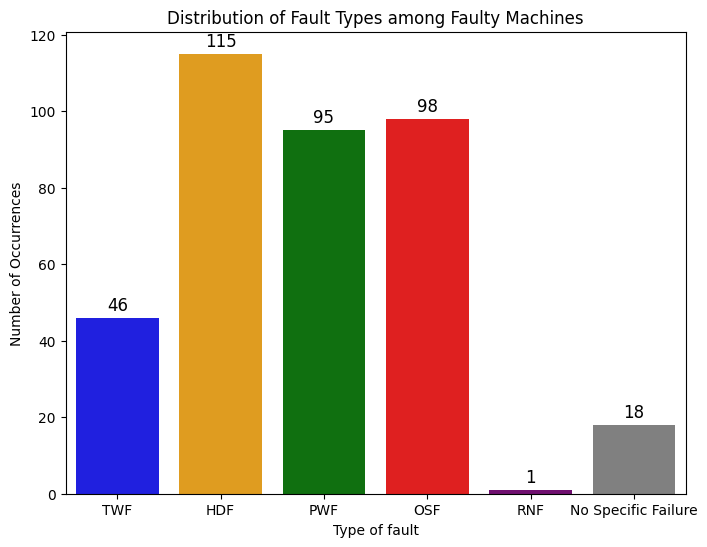

In [342]:
failed_machines = df[df["Machine failure"] == 1]

failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = failed_machines[failure_types].sum()

no_specific_failure = df[(df["Machine failure"] == 0) & (df["RNF"] == 1)].shape[0]

failure_counts["No Specific Failure"] = no_specific_failure

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=failure_counts.index, y=failure_counts.values,  palette=['blue', 'orange', 'green', 'red', 'purple', 'gray'])

for i, value in enumerate(failure_counts.values):
    ax.text(i, value + 2, str(value), ha='center', fontsize=12)

plt.xlabel("Type of fault")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Fault Types among Faulty Machines")

plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

Mais uma vez há uma discrepancia no número de amostras nas maquinás que obtiveram falhas, onde apenas 1 foi caracterizada como RNF e 115 como HDF

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [343]:
print("Column Names and Data Types:")
print(df.dtypes)

Column Names and Data Types:
UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

Para treinar o modelo, as entradas escolhidas serão as variáveis que indicam o uso da máquina e situação fisica dela, como Air temperature, Process temperature, Rotational speed, Torque, Tool wear e Type, pois influenciam diretamente no desempenho e possíveis falhas. As saídas
serão Machine failure e as colunas com os tipos de falhas como TWF, HDF, PWF e OSF, retirei RNF pois sua quantidade é irrisória em comparação com as outras falhas e principalmente porque são falhas aleatórias. Isso acarreta em uma previsão sobre os possiveis problemas além de permitir ações de manutenção preditiva baseadas nas condições da máquina.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [344]:
# Criar variáveis dummies para a coluna 'Type'
df = pd.get_dummies(df, columns=['Type'], drop_first=False)


In [345]:
# Definir X (remover IDs e variáveis de saída)
X = df.drop(columns=['UDI', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])

# Definir y (agora multi-label: cada falha é independente)
Y = df[['Machine failure','TWF', 'HDF', 'PWF', 'OSF']]

# Criar coluna "No Failure"
#Y['No Failure'] = (df['Machine failure'] == 0).astype(int)

# Normalizar X para intervalo [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# print das colunas de x e y
print(X.head())
print(Y.head())
# Divisão treino (70%) e teste (30%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Exibir dimensões
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0             0.304348                 0.358025                0.222934   
1             0.315217                 0.370370                0.139697   
2             0.304348                 0.345679                0.192084   
3             0.315217                 0.358025                0.154249   
4             0.315217                 0.370370                0.139697   

   Torque [Nm]  Tool wear [min]  Type_H  Type_L  Type_M  
0     0.535714         0.000000     0.0     0.0     1.0  
1     0.583791         0.011858     0.0     1.0     0.0  
2     0.626374         0.019763     0.0     1.0     0.0  
3     0.490385         0.027668     0.0     1.0     0.0  
4     0.497253         0.035573     0.0     1.0     0.0  
   Machine failure  TWF  HDF  PWF  OSF
0                0    0    0    0    0
1                0    0    0    0    0
2                0    0    0    0    0
3                0    0    0    0    0
4     





**QUESTION** Code below the model architecture

In [346]:

# Criar o modelo aprimorado para multi-label
model = Sequential([
    Dense(64, kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),

    Dense(32, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),

    Dense(5, activation='sigmoid')  # 5 classes: Machine Failure, TWF, HDF, PWF, OSF
])

# Compilar o modelo com métricas ajustadas
model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.01),
              loss='binary_crossentropy',  # Multi-label classification
              metrics=['binary_accuracy', AUC(name='auc')])

# Exibir resumo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_220 (Dense)                    │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_152              │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_156 (LeakyReLU)          │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_154 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_221 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_153              │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_157 (LeakyReLU)          │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_155 (Dropout)                │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_222 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,205 (12.52 KB)

 Trainable params: 3,013 (11.77 KB)

 Non-trainable params: 192 (768.00 B)

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - auc: 0.5216 - binary_accuracy: 0.7152 - loss: 1.0464 - val_auc: 0.6642 - val_binary_accuracy: 0.9873 - val_loss: 0.6607 - learning_rate: 0.0010
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.6480 - binary_accuracy: 0.9572 - loss: 0.4191 - val_auc: 0.6648 - val_binary_accuracy: 0.9873 - val_loss: 0.2996 - learning_rate: 0.0010
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.6938 - binary_accuracy: 0.9829 - loss: 0.1900 - val_auc: 0.7650 - val_binary_accuracy: 0.9873 - val_loss: 0.1513 - learning_rate: 0.0010
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - auc: 0.7373 - binary_accuracy: 0.9828 - loss: 0.1193 - val_auc: 0.8113 - val_binary_accuracy: 0.9873 - val_loss: 0.1055 - learning_rate: 0.0010
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.8259 - binary_accuracy: 0.9838 - loss: 0.0901 - val_auc: 0.8824 - val_binary_accuracy: 0.9873 - val_loss: 0.0815 - learning_rate: 0.0010
Epoch 6/50

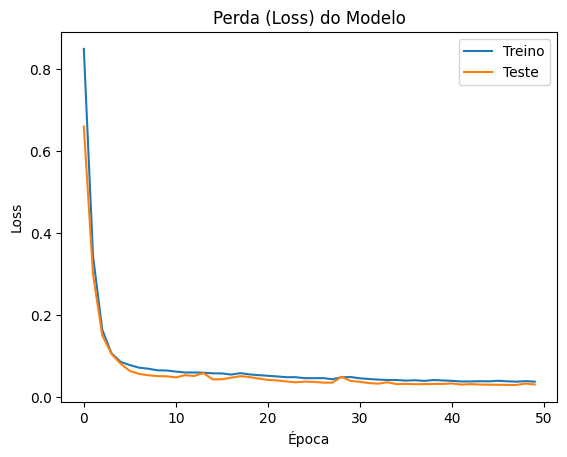

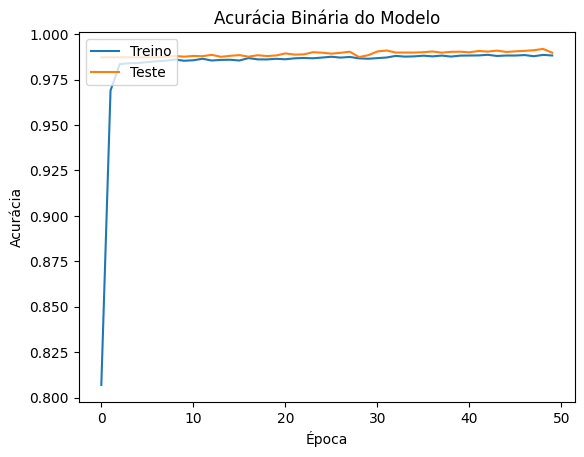

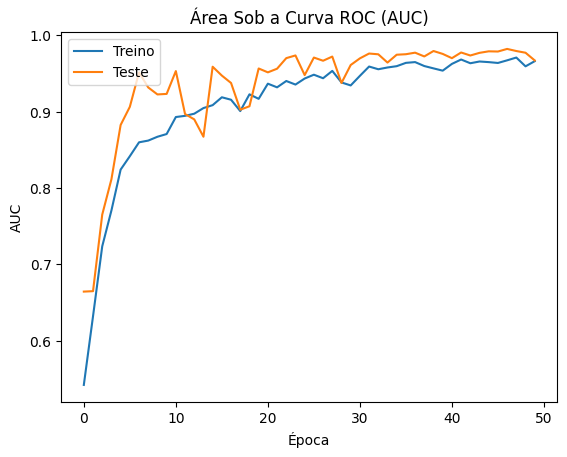

In [347]:


# Definir callbacks otimizados
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)

# Treinar modelo
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

#Função para plotar métricas corretamente para multi-label
def plot_metric(history, metric, title, ylabel, loc='upper left'):
    if metric in history.history:
        plt.plot(history.history[metric], label='Treino')
    if f'val_{metric}' in history.history:
        plt.plot(history.history[f'val_{metric}'], label='Teste')

    plt.title(title)
    plt.xlabel('Época')
    plt.ylabel(ylabel)
    plt.legend(loc=loc)
    plt.show()

#Plotar a perda (loss)
plot_metric(history, 'loss', 'Perda (Loss) do Modelo', 'Loss', loc='upper right')

#  Plotar acurácia binária (para multi-label)
plot_metric(history, 'binary_accuracy', 'Acurácia Binária do Modelo', 'Acurácia')

#  Plotar AUC (Área Sob a Curva ROC)
plot_metric(history, 'auc', 'Área Sob a Curva ROC (AUC)', 'AUC')


**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





In [358]:

# Fazer previsões em probabilidades
Y_pred_probs = model.predict(X_test)

# Ajustar threshold dinamicamente baseado na média das probabilidades
thresholds = np.mean(Y_pred_probs, axis=0)  # Calcula média por classe
Y_pred = (Y_pred_probs >= thresholds).astype(int)  # Ajusta decisão para cada classe

#  Gerar relatório de classificação
labels = ['Machine Failure', 'TWF', 'HDF', 'PWF', 'OSF']
report = classification_report(Y_test, Y_pred, target_names=labels)
print("\nRelatório de Classificação:")
print(report)

# Criar matrizes de confusão para cada classe
cm_matrices = multilabel_confusion_matrix(Y_test, Y_pred)

# Plotar as matrizes de confusão separadas por classe
for i, label in enumerate(labels):
    cm = cm_matrices[i].astype('float') / cm_matrices[i].sum(axis=1, keepdims=True) * 100  # Normalizar para porcentagem

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Matriz de Confusão - {label} (%)")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()





array([0.18307965, 0.02901097, 0.0851706 , 0.053411  , 0.03361649],
      dtype=float32)

**ANALYSIS QUESTION** What do you observe? What can you conclude?

O modelo ficou bom em prever quando não há falhas, porém ele não consegue prever quando há, e sempre a respota que prevalece é que não houve, dado que o numero de maquinas sem falhas é muito maior em comparação com as maquinas com falhas.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [350]:
data_path = "/content/ai4i2020.csv"
df = pd.read_csv(data_path)

#separa os tipos das maquinas em booleanos
df = pd.get_dummies(df, columns=['Type'], drop_first=False)


In [351]:

#Definir X e Y antes do balanceamento
X = df.drop(columns=['UDI', 'Product ID', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
Y = df[['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF']]

In [352]:
# Aplicar Undersampling APENAS para `Machine Failure`
undersampler = RandomUnderSampler(sampling_strategy=0.3, random_state=42)  # Mantém 30% dos "No Failure"
X_resampled, y_machine_failure = undersampler.fit_resample(X, Y['Machine failure'])  # Apenas Machine Failure

# Recuperar os índices selecionados pelo undersampling
selected_indices = y_machine_failure.index

# Filtrar `Y` completo para manter os rótulos corretos das amostras balanceadas
Y_resampled = Y.loc[selected_indices]

# Normalizar X para intervalo [0,1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_resampled)
X_resampled = pd.DataFrame(X_scaled, columns=X.columns)

# Agora dividir em treino (70%) e teste (30%)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_resampled, Y_resampled, test_size=0.2, random_state=42)

# Exibir dimensões finais
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train, Y_train
X_test, Y_test


X_train shape: (1175, 8), Y_train shape: (1175, 5)
X_test shape: (294, 8), Y_test shape: (294, 5)


(      Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
 1406             0.595506                 0.705128                0.089639   
 184              0.786517                 0.705128                0.294529   
 1221             0.764045                 0.641026                0.122817   
 67               0.539326                 0.576923                0.189173   
 220              0.573034                 0.782051                0.292200   
 ...                   ...                      ...                     ...   
 567              0.280899                 0.512821                0.136787   
 560              0.516854                 0.717949                0.176368   
 944              0.640449                 0.512821                0.112922   
 522              0.235955                 0.474359                0.146100   
 650              0.415730                 0.410256                0.174622   
 
       Torque [Nm]  Tool wear [min]  Type_H  Type_

<ipython-input-353-63e6a673fb5b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette=['blue', 'red'])


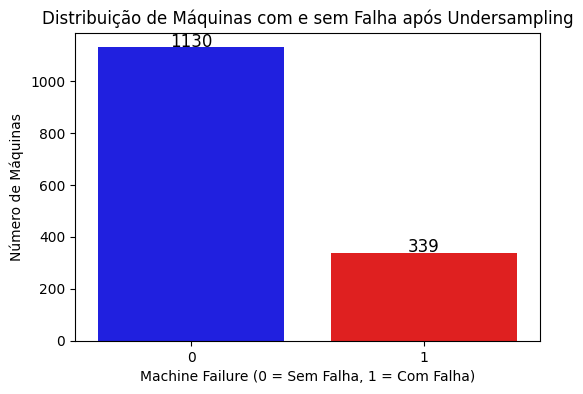

In [353]:
# Contar a quantidade de máquinas com e sem falha após o undersampling
failure_counts = Y_resampled['Machine failure'].value_counts()

# Plotar a distribuição das máquinas após o undersampling
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette=['blue', 'red'])

# Adicionar valores acima das barras
for i, value in enumerate(failure_counts.values):
    ax.text(i, value + 2, str(value), ha='center', fontsize=12)

plt.xlabel("Machine Failure (0 = Sem Falha, 1 = Com Falha)")
plt.ylabel("Número de Máquinas")
plt.title("Distribuição de Máquinas com e sem Falha após Undersampling")

# Exibir o gráfico
plt.show()

**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

Eu usei somente o undersampling pois a técnica SMOTE não é aconselhada para problemas do tipo mult label, e a técnica class weight deixava os dados treinados para aprender somente quando há falhas, e muitas vezes não condiz com o resultado real. Já a técnica undersampling eu consgio reduzir o meu data frame sem criar valores irreais, e aproximar o tamanho dos vetores de Machine failure e No failure de forma que o treino não fique com viés viciado.

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [354]:

# Criar o modelo aprimorado para multi-label
model = Sequential([
    Dense(64, kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),

    Dense(32, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.3),

    Dense(5, activation='sigmoid')  # 5 classes: Machine Failure, TWF, HDF, PWF, OSF
])

# Compilar o modelo com métricas ajustadas
model.compile(optimizer=AdamW(learning_rate=0.001, weight_decay=0.01),
              loss='binary_crossentropy',  # Multi-label classification
              metrics=['binary_accuracy', AUC(name='auc')])

# Exibir resumo
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_223 (Dense)                    │ (None, 64)                  │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_154              │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_158 (LeakyReLU)          │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_156 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_224 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_155              │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_159 (LeakyReLU)          │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_157 (Dropout)                │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_225 (Dense)                    │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,205 (12.52 KB)

 Trainable params: 3,013 (11.77 KB)

 Non-trainable params: 192 (768.00 B)

**QUESTION** Code below the algorithms allowing to train model


Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - auc: 0.5725 - binary_accuracy: 0.4814 - loss: 1.4057 - val_auc: 0.6551 - val_binary_accuracy: 0.5293 - val_loss: 1.2087 - learning_rate: 0.0010
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6171 - binary_accuracy: 0.5593 - loss: 1.2298 - val_auc: 0.6781 - val_binary_accuracy: 0.6531 - val_loss: 1.1338 - learning_rate: 0.0010
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6485 - binary_accuracy: 0.6405 - loss: 1.0837 - val_auc: 0.6855 - val_binary_accuracy: 0.7837 - val_loss: 1.0629 - learning_rate: 0.0010
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6661 - binary_accuracy: 0.7045 - loss: 0.9739 - val_auc: 0.6938 - val_binary_accuracy: 0.8714 - val_loss: 0.9877 - learning_rate: 0.0010
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.6988 - binary_accuracy: 0.7719 - loss: 0.8552 - val_auc: 0.7107 - val_binary_accuracy: 0.8952 - val_loss: 0.9144 - learning_rate: 0.0010
Epoch 6/50
19/1

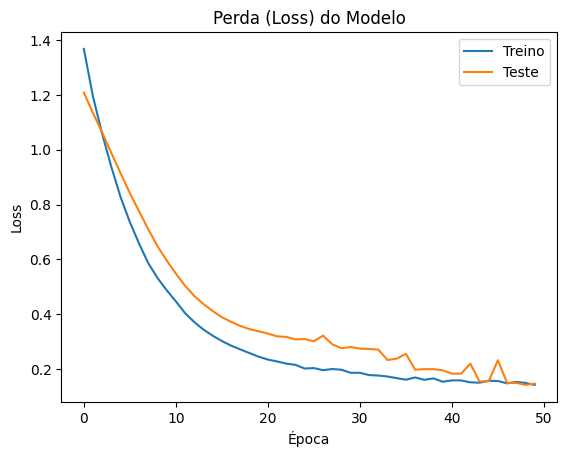

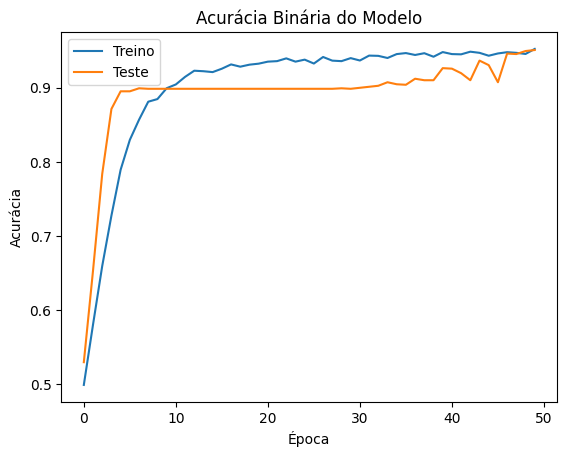

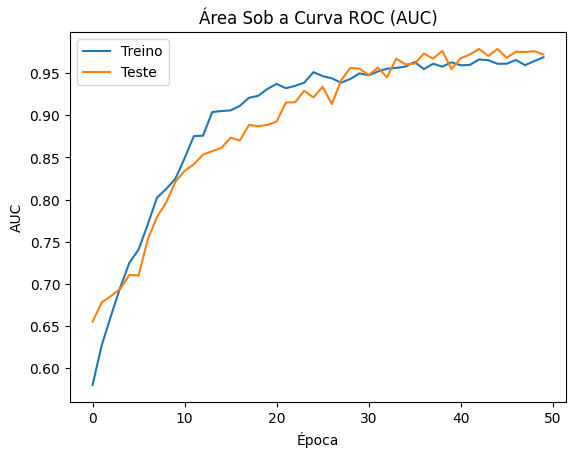

In [355]:
# Definir callbacks otimizados
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1)


# Treinar o modelo com os dados balanceados e pesos ajustados
history = model.fit(
    X_train,
    Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

#Função para plotar métricas corretamente para multi-label
def plot_metric(history, metric, title, ylabel, loc='upper left'):
    if metric in history.history:
        plt.plot(history.history[metric], label='Treino')
    if f'val_{metric}' in history.history:
        plt.plot(history.history[f'val_{metric}'], label='Teste')

    plt.title(title)
    plt.xlabel('Época')
    plt.ylabel(ylabel)
    plt.legend(loc=loc)
    plt.show()

#Plotar a perda (loss)
plot_metric(history, 'loss', 'Perda (Loss) do Modelo', 'Loss', loc='upper right')

#  Plotar acurácia binária (para multi-label)
plot_metric(history, 'binary_accuracy', 'Acurácia Binária do Modelo', 'Acurácia')

#  Plotar AUC (Área Sob a Curva ROC)
plot_metric(history, 'auc', 'Área Sob a Curva ROC (AUC)', 'AUC')


**QUESTION** Plot the confusion matrix and the classification report

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Relatório de Classificação:
                 precision    recall  f1-score   support

Machine Failure       0.79      0.85      0.82        74
            TWF       0.10      1.00      0.19         8
            HDF       0.38      1.00      0.55        23
            PWF       0.66      0.95      0.78        22
            OSF       0.55      1.00      0.71        22

      micro avg       0.47      0.92      0.62       149
      macro avg       0.50      0.96      0.61       149
   weighted avg       0.63      0.92      0.72       149
    samples avg       0.20      0.23      0.21       149



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


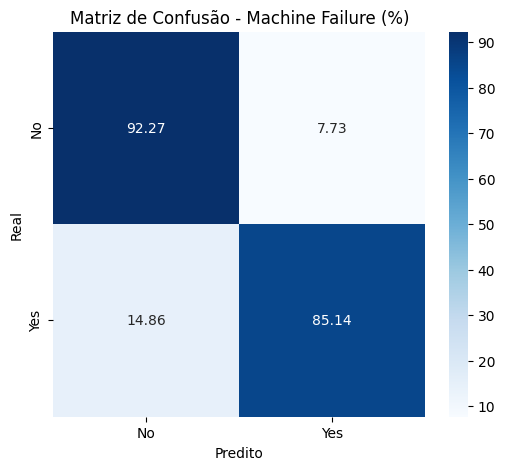

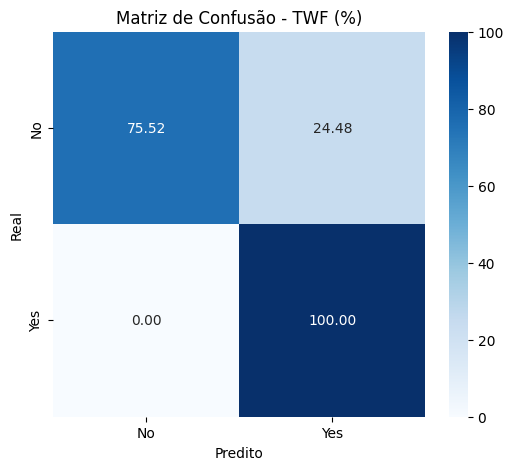

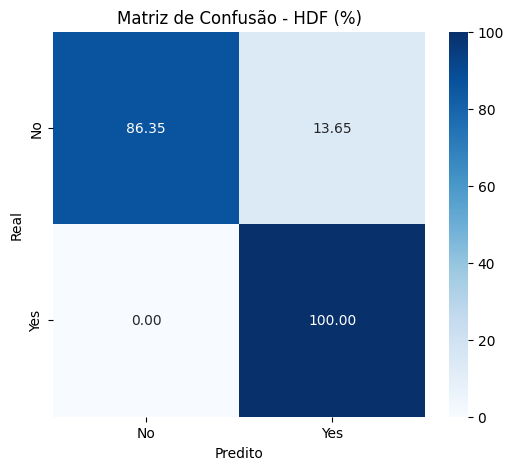

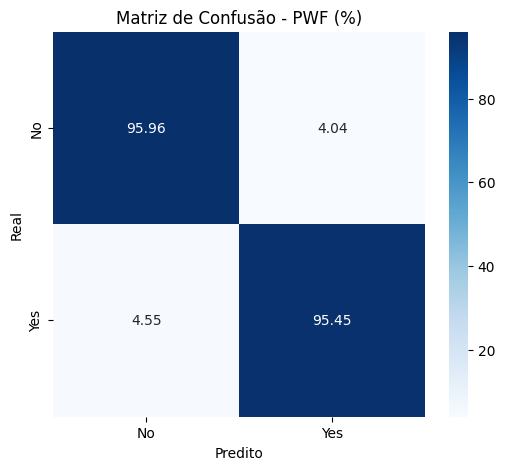

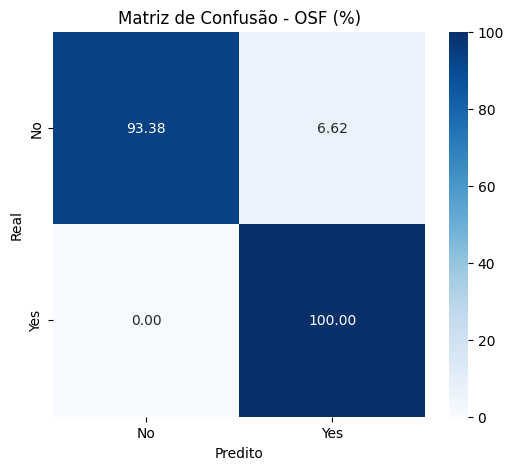

In [356]:

# Fazer previsões em probabilidades
Y_pred_probs = model.predict(X_test)

# Ajustar threshold dinamicamente baseado na média das probabilidades
thresholds = np.mean(Y_pred_probs, axis=0)  # Calcula média por classe
Y_pred = (Y_pred_probs >= thresholds).astype(int)  # Ajusta decisão para cada classe

#  Gerar relatório de classificação
labels = ['Machine Failure', 'TWF', 'HDF', 'PWF', 'OSF']
report = classification_report(Y_test, Y_pred, target_names=labels)
print("\nRelatório de Classificação:")
print(report)

# Criar matrizes de confusão para cada classe
cm_matrices = multilabel_confusion_matrix(Y_test, Y_pred)

# Plotar as matrizes de confusão separadas por classe
for i, label in enumerate(labels):
    cm = cm_matrices[i].astype('float') / cm_matrices[i].sum(axis=1, keepdims=True) * 100  # Normalizar para porcentagem

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"Matriz de Confusão - {label} (%)")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()


**ANALYSIS QUESTION** What do you observe? What can you conclude?

Foi melhorado grandemente em comparação com os dados sem balanceamento, uma vez que retirei uma parte das amostras que não possuiam falhas, pois o numero era grande demais comparado com maquinas que tinham falhas. Outro ponto a ser analisado é que meu modelo atual ainda não possui perfeita precisão, pois ele aponta muitos falsos positivos, porém não vejo como algo crítico, pois o caso de não previsão quando há falhas pode acarretar em perdas maiores.